In [1]:
# Step 1: Import Necessary Libraries
import os
import time
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import models
import torchvision.transforms as T
import matplotlib.cm as cm
from tqdm import tqdm

In [2]:
# Step 2: Define Utility Functions
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [3]:
#Set Device and Model Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model_path = 'bisenet_model.pth'

cuda


In [4]:
#Specify Paths and Configuration
image_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_path = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

In [5]:
#Load and Preprocess Data for Visualization
names2 = ['X_mask_190','X_mask_191','X_mask_192']
names = ['X_seismic_190','X_seismic_191','X_seismic_192']
images = [Image.open(os.path.join(image_path, name+'.png')) for name in names]
masks = [Image.open(os.path.join(mask_path, name+'.png')) for name in names2]

transforms = T.Compose([T.Grayscale(), T.ToTensor()])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

In [6]:
x.shape

torch.Size([3, 1, 369, 496])

In [7]:
y.shape

torch.Size([3, 1, 369, 496])

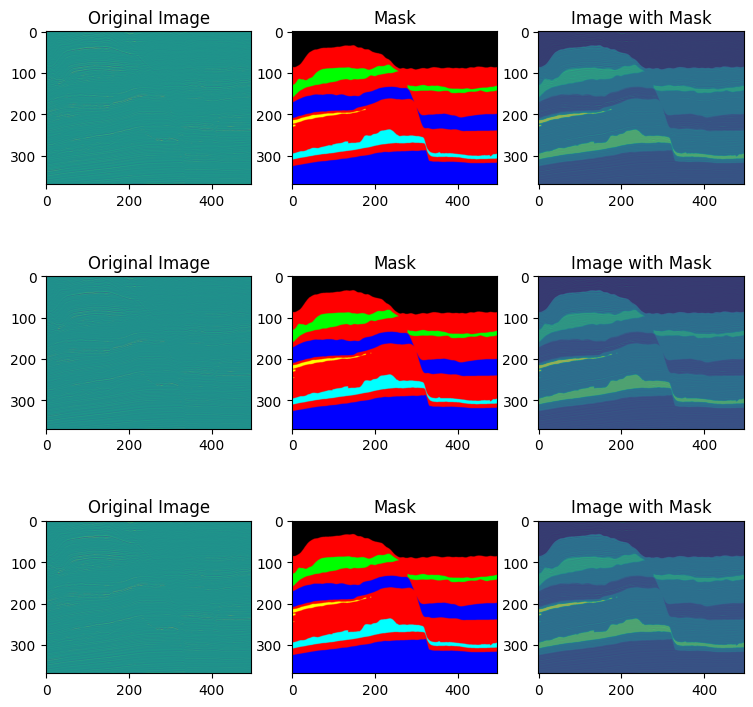

In [8]:
# Step 6: Visualize Sample Data
fig = plt.figure(figsize=(9, 9))
num_images = len(images)
for i in range(num_images):
    ax = fig.add_subplot(num_images, 3, i*3+1)
    ax.imshow(images[i])
    ax.set_title("Original Image")

    ax = fig.add_subplot(num_images, 3, i*3+2)
    ax.imshow(masks[i])
    ax.set_title("Mask")

    ax = fig.add_subplot(num_images, 3, i*3+3)
    ax.imshow(x[i].squeeze())
    ax.imshow(y[i].squeeze(), alpha=0.5)
    ax.set_title("Image with Mask")

plt.show()

In [9]:
# Step 7: Define Custom Dataset Class
class SegmentDataset(Dataset):

    color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
    ]

    def __init__(self, image_paths, mask_paths, num_classes=7):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.num_classes=num_classes

#         self.transforms = T.Compose([T.Grayscale(), T.ToTensor()])
        self.transforms = T.Compose([T.ToTensor()])

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx])
        image = image.convert('RGB')
        
        image = self.transforms(image)
        resized_image = T.Resize((204, 204))(image)
        
        mask = Image.open(self.mask_paths[idx])
        mask = mask.convert('RGB')
        mask = np.array(mask)
        mask = self.label_for_cross_entropy(mask)
        mask = Image.fromarray(mask)
        resized_mask = T.Resize((204, 204))(mask)
        resized_mask = np.array(resized_mask)
        
        return resized_image, torch.from_numpy(resized_mask).long()

    def label_for_cross_entropy(self, label):
        """
            Convert label image to matrix classes for apply cross entropy loss.
            Return semantic index, label in enumemap of H x W x class
        """
        semantic_map = np.zeros(label.shape[:-1])
        # Fill all value with class 13 - default for all pixels
        semantic_map.fill(self.num_classes - 1)
        # Fill the pixel with correct class

        for class_index, color_info in enumerate(self.color_encoding):
            color = color_info[1]
            equality = np.equal(label, color)
            class_map = np.all(equality, axis=-1)
            semantic_map[class_map] = class_index
        return semantic_map

    def __len__(self):
        return len(self.mask_paths)

In [10]:
import os
from sklearn.model_selection import train_test_split

# Paths to your image and mask folders
image_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic"
mask_folder = "/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask"

# List all files in the image and mask folders
image_files = [os.path.join(image_folder, file) for file in os.listdir(image_folder) if file.endswith('.png')]
mask_files = [os.path.join(mask_folder, file).replace('seismic', 'mask') for file in image_files]

# Split files into training and validation sets
image_train, image_val, mask_train, mask_val = train_test_split(image_files, mask_files, test_size=0.2, random_state=42)

# Verify the lengths of the training and validation sets
print(f"Number of training samples: {len(image_train)}")
print(f"Number of validation samples: {len(image_val)}")

# Optionally, you can create separate lists for training and validation images and masks
training_image_paths = image_train
training_mask_paths = mask_train
val_image_paths = image_val
val_mask_paths = mask_val

/home/sang/Desktop/venv39/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Number of training samples: 625
Number of validation samples: 157


In [11]:
image_train

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic/X_seismic_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/ex

In [12]:
training_mask_paths

['/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_167.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_188.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_75.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_262.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_239.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_364.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_261.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_438.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_745.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_56.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_218.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_208.png',
 '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask/X_mask_332.png',
 '/home/sang/Documents/Dataset/SEG_2020/

In [13]:
# Step 8: Initialize Dataset
train_dataset = SegmentDataset(training_image_paths, training_mask_paths)
# Step 5: Validation Dataset
val_dataset = SegmentDataset(val_image_paths, val_mask_paths)

In [14]:
# Step 6: Validation DataLoader
BATCH_SIZE = 16
dataloader_val = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

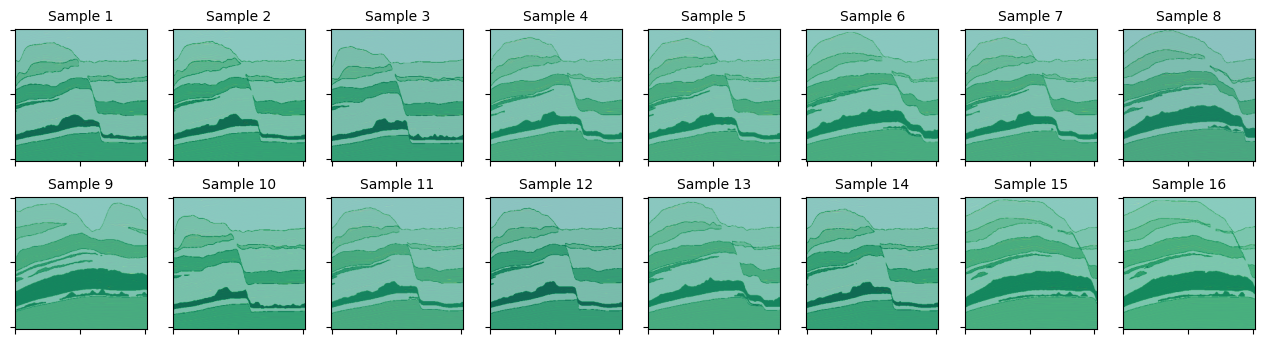

In [15]:

# Step 9: Visualize More Data from Dataset
max_images = 16
grid_width = 8
grid_height = max_images // grid_width
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width * 2, grid_height * 2))

for i in range(max_images):
    image, mask = train_dataset[i]
    image = np.transpose(image, (1, 2, 0))
    ax = axs[i // grid_width, i % grid_width]
    ax.imshow(image.squeeze(), cmap="Greys")
    ax.imshow(mask.squeeze(), alpha=0.5, cmap="Greens")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(f"Sample {i+1}", fontsize=10)

# # Add color bar to indicate mask colors
# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(cm.ScalarMappable(cmap='Greens'), cax=cax)
# cbar.set_label('Mask Colors')

plt.show()

In [16]:
# Step 10: Define Model Architecture
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=2, padding=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding
        )

        self.batch_norm = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.batch_norm(x)
        return self.relu(x)

"""
Defines ChannelAttention class
"""
class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction_rate=16):
        super(ChannelAttention, self).__init__()
        self.squeeze = nn.ModuleList([
            nn.AdaptiveAvgPool2d(1),
            nn.AdaptiveMaxPool2d(1)
        ])
        
        self.excitation = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                      out_channels=channels // reduction_rate,
                      kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=channels // reduction_rate,
                      out_channels=channels,
                      kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # perform squeeze with independent Pooling
        avg_feat = self.squeeze[0](x)
        max_feat = self.squeeze[1](x)
        # perform excitation with the same excitation sub-net
        avg_out = self.excitation(avg_feat)
        max_out = self.excitation(max_feat)
        # attention
        attention = self.sigmoid(avg_out + max_out)
        return attention * x
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(
            in_channels=2,
            out_channels=1,
            kernel_size=kernel_size,
            padding=kernel_size // 2
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # mean on spatial dim
        avg_feat    = torch.mean(x, dim=1, keepdim=True)
        # max on spatial dim
        max_feat, _ = torch.max(x, dim=1, keepdim=True)
        feat = torch.cat([avg_feat, max_feat], dim=1)
        out_feat = self.conv(feat)
        attention = self.sigmoid(out_feat)
        return attention * x
    
class SpatialPath(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvBlock(kernel_size=3, stride=1, in_channels=3, out_channels=64)
        self.c_attention1 = ChannelAttention(64)
        self.conv2 = ConvBlock(kernel_size=3, stride=1, in_channels=64, out_channels=128)
        self.c_attention2 = ChannelAttention(128)
        self.conv3 = ConvBlock(kernel_size=3, stride=1, in_channels=128, out_channels=256)
        self.c_attention3 = ChannelAttention(256)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.c_attention1(x)
        x = self.conv2(x)
        x = self.c_attention2(x)
        x = self.conv3(x)
        x = self.c_attention3(x)
        return x

# class SpatialPath(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = ConvBlock(in_channels=3, out_channels=64)
#         self.c_attention1 = ChannelAttention(64)
#         self.s_attention1 = SpatialAttention()
#         self.conv2 = ConvBlock(in_channels=64, out_channels=128)
#         self.c_attention2 = ChannelAttention(128)
#         self.s_attention2 = SpatialAttention()
#         self.conv3 = ConvBlock(in_channels=128, out_channels=256)
#         self.c_attention3 = ChannelAttention(256)
#         self.s_attention3 = SpatialAttention()
        
#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.c_attention1(x)
# #         x = self.s_attention1(x)
#         x = self.conv2(x)
#         x = self.c_attention2(x)
# #         x = self.s_attention2(x)
#         x = self.conv3(x)
#         x = self.c_attention3(x)
# #         x = self.s_attention3(x)
#         return x

class ContextPath(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.features=models.resnet18(pretrained=pretrained)
        self.conv1=self.features.conv1
        self.bn1=self.features.bn1
        self.relu=self.features.relu
        self.max_pool=self.features.maxpool
        self.layer1=self.features.layer1
        self.layer2=self.features.layer2
        self.layer3=self.features.layer3
        self.layer4=self.features.layer4
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)

        feature1 = self.layer1(x)
        feature2 = self.layer2(feature1)
        feature3 = self.layer3(feature2)
        feature4 = self.layer4(feature3)

        tail = self.avg_pool(feature4)
        return feature3, feature4, tail

class AttentionRefinementModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.conv=nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=1)
        self.bn=nn.BatchNorm2d(out_channels)
        self.sigmoid=nn.Sigmoid()
        self.in_channels=in_channels

    def forward(self, x_input):
        x = self.avg_pool(x_input)
        assert x.size(1) == self.in_channels,  'in_channels and out_channels should all be {}'.format(x.size(1))

        x = self.conv(x)
        x = self.bn(x)
        x = self.sigmoid(x)

        # Channel of x_input and x must be same
        return torch.mul(x_input, x)

class FeatureFusionModule(nn.Module):
    def __init__(self, num_classes, in_channels):
        super().__init__()
        self.in_channels=in_channels
        self.conv_block=ConvBlock(in_channels=in_channels, out_channels=num_classes, stride=1)
        self.conv1=nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.relu=nn.ReLU()
        self.conv2=nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)
        self.sigmoid=nn.Sigmoid()
        self.avg_pool=nn.AdaptiveAvgPool2d(output_size=(1,1))

    def forward(self, x_input_1, x_input_2):
        x = torch.cat((x_input_1, x_input_2), dim=1)
        assert self.in_channels == x.size(1), 'in_channels of ConvBlock should be {}'.format(x.size(1))
        feature = self.conv_block(x)

        # Apply above branch in feature
        x = self.avg_pool(feature)
        x = self.relu(self.conv1(x))
        x = self.sigmoid(self.conv2(x))

        # Multipy feature and x
        x = torch.mul(feature, x)

        # Combine feature and x
        return torch.add(feature, x)

In [17]:
# Step 11: Define BiSeNet Model
class BiSeNet(nn.Module):
    def __init__(self, num_classes, training=True):
        super().__init__()
        self.training = training
        self.spatial_path = SpatialPath()
        self.context_path = ContextPath()
        self.arm1 = AttentionRefinementModule(in_channels=256, out_channels=256)
        self.arm2 = AttentionRefinementModule(in_channels=512, out_channels=512)

        # Supervision for calculate loss
        self.supervision1 = nn.Conv2d(in_channels=256, out_channels=num_classes, kernel_size=1)
        self.supervision2 = nn.Conv2d(in_channels=512, out_channels=num_classes, kernel_size=1)

        # Feature fusion module
        self.ffm = FeatureFusionModule(num_classes=num_classes, in_channels=1024)

        # Final convolution
        self.conv = nn.Conv2d(in_channels=num_classes, out_channels=num_classes, kernel_size=1)

    def forward(self, x_input):
        # Spatial path output
        sp_out = self.spatial_path(x_input)

        # Context path output
        feature1, feature2, tail = self.context_path(x_input)

        # apply attention refinement module
        feature1, feature2 = self.arm1(feature1), self.arm2(feature2)

        # Combine output of lightweight model with tail
        feature2 = torch.mul(feature2, tail)

        # Up sampling
        size2d_out = sp_out.size()[-2:]
        feature1 = F.interpolate(feature1, size=size2d_out, mode='bilinear')
        feature2 = F.interpolate(feature2, size=size2d_out, mode='bilinear')
        context_out = torch.cat((feature1, feature2), dim=1)

        # Apply Feature Fusion Module
        combine_feature = self.ffm(sp_out, context_out)

        # Up sampling
        bisenet_out = F.interpolate(combine_feature, scale_factor=1, mode='bilinear')
        bisenet_out = self.conv(bisenet_out)

        # When training model
        if True:
            feature1_sup = self.supervision1(feature1)
            feature2_sup = self.supervision2(feature2)
            feature1_sup = F.interpolate(feature1_sup, size=x_input.size()[-2:], mode='bilinear')
            feature2_sup = F.interpolate(feature2_sup, size=x_input.size()[-2:], mode='bilinear')
            return bisenet_out, feature1_sup, feature2_sup
        return bisenet_out

In [18]:
# Step 14.1: Define Helper Functions

def reverse_one_hot(image):
    # Convert output of model to predicted class
    image = image.permute(0, 2, 3, 1)
    x = torch.argmax(image, dim=-1)
    return x

def compute_accuracy(pred, label):
    pred = pred.flatten()
    label = label.flatten()
    total = len(label)
    count = 0.0
    for i in range(total):
        if pred[i] == label[i]:
            count = count + 1.0
    return float(count) / float(total)

In [19]:
# Step 14.2: Get IoU Score
def fast_hist(a, b, n):
    k = (a >= 0) & (a < n)
    return np.bincount(n * a[k].astype(int) + b[k], minlength=n ** 2).reshape(n, n)

def per_class_iu(hist):
    epsilon = 1e-5
    return (np.diag(hist) + epsilon) / (hist.sum(1) + hist.sum(0) - np.diag(hist) + epsilon)

In [20]:
# Step 15: Get validate function
NUM_CLASSES=7
def val(model, dataloader):
    accuracy_arr = []

    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))

    with torch.no_grad():
        model.eval()
        print('Starting validate')
        
        val_loss_record = []
        
        for i, (val_data, val_label) in enumerate(dataloader):
            val_data = val_data.cuda()
            val_label_cuda = val_label.cuda()
            # The output of model is (1, num_classes, W, H) => (num_classes, W, H)
            val_output, val_output_sup1, val_output_sup2 = model(val_data)
            
            val_loss1 = loss_func(val_output, val_label_cuda)
            val_loss2 = loss_func(val_output_sup1, val_label_cuda)
            val_loss3 = loss_func(val_output_sup2, val_label_cuda)

            # Combine 3 loss
            val_loss = val_loss1 + val_loss2 + val_loss3
            
            val_output = val_output.squeeze()
            val_output_sup1 = val_output_sup1.squeeze()
            val_output_sup2 = val_output_sup1.squeeze()
            # Convert the (num_classes, W, H) => (W, H) with one hot decoder
            val_output = reverse_one_hot(val_output)
            val_output = np.array(val_output.cpu())
            # Process label. Convert to (W, H) image
            val_label = val_label.squeeze()
            val_label = np.array(val_label.cpu())
            # Compute accuracy and iou
            accuracy = compute_accuracy(val_output, val_label)
            hist += fast_hist(val_label.flatten(), val_output.flatten(), NUM_CLASSES)
            # Append for calculate
            accuracy_arr.append(accuracy)
            val_loss_record.append(loss.item())
            
        val_loss_mean = np.mean(val_loss_record)
        miou_list = per_class_iu(hist)[:-1]
        mean_accuracy, mean_iou = np.mean(accuracy_arr), np.mean(miou_list)
        print('Mean validate loss: {} Mean validate IoU: {}'.format(val_loss_mean, mean_iou))
        return mean_accuracy, mean_iou, val_loss_mean

In [21]:
# Step 16.1: Create DataLoader for Training Dataset
dataloader_train = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
steps = len(train_dataset) // BATCH_SIZE
print(steps, "steps per epoch")

39 steps per epoch


In [22]:
# Step 16.3: Define model and training function, hyperparameters
EPOCHS = 200
LEARNING_RATE = 0.001
BATCH_SIZE = 16
CHECKPOINT_STEP = 2
VALIDATE_STEP = 1

model = BiSeNet(num_classes=NUM_CLASSES, training=True).to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')

loss_func = torch.nn.CrossEntropyLoss()

/home/sang/Desktop/venv39/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/sang/Desktop/venv39/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
# Step 16.2: Model Training

# Loop for training
torch.cuda.empty_cache()

max_miou = 0
max_miou_epoch = 0

train_iou_hist = []
val_iou_hist = []

train_loss_hist = []
val_loss_hist = []

for epoch in range(EPOCHS):
    model.train()
    tq = tqdm(total=len(dataloader_train) * BATCH_SIZE)
    tq.set_description('Epoch {}/{}'.format(epoch + 1, EPOCHS))
    
    hist = np.zeros((NUM_CLASSES, NUM_CLASSES))
    loss_record = []

    for i, (data, label) in enumerate(dataloader_train):
        data = data.cuda()
        label = label.cuda()
        output, output_sup1, output_sup2 = model(data)
        loss1 = loss_func(output, label)
        loss2 = loss_func(output_sup1, label)
        loss3 = loss_func(output_sup2, label)

        # Combine 3 loss
        loss = loss1 + loss2 + loss3
        tq.update(BATCH_SIZE)
        tq.set_postfix(loss='%.6f' % loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_record.append(loss.item())
        
        output = reverse_one_hot(output)
        output = np.array(output.cpu())
        
        hist += fast_hist(label.flatten().detach().cpu().numpy(), output.flatten(), NUM_CLASSES)
        
    tq.close()
    loss_train_mean = np.mean(loss_record)
    miou_list = per_class_iu(hist)[:-1]
    mean_iou = np.mean(miou_list)
    
    train_iou_hist = train_iou_hist + [mean_iou]
    train_loss_hist = train_loss_hist + [loss_train_mean]
    
    print('loss for train : %f' % (loss_train_mean))
    print('IoU for train : %f' % (mean_iou))
    
    # Save checkpoint
    if epoch % CHECKPOINT_STEP == 0:
        torch.save(model.state_dict(), 'lastest_model_bisenet.pth')

    # Validate save best model
    # Save checkpoint
    if epoch % VALIDATE_STEP == 0:
        _, mean_iou, val_loss = val(model, dataloader_val)
        val_iou_hist = val_iou_hist + [mean_iou]
        val_loss_hist = val_loss_hist + [val_loss]
        if mean_iou > max_miou:
            max_miou = mean_iou
            max_miou_epoch = epoch + 1
            print('Save best model with mIoU = {}'.format(mean_iou))
            torch.save(model.state_dict(), 'best_model_bisenet.pth')
        else:
            print('Best mIoU: {} at epoch {}'.format(max_miou, max_miou_epoch))

Epoch 1/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:42<00:00,  6.09it/s, loss=2.788831]


loss for train : 3.487731
IoU for train : 0.404206
Starting validate
Mean validate loss: 2.788830518722534 Mean validate IoU: 0.47532740937582146
Save best model with mIoU = 0.47532740937582146


Epoch 2/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:27<00:00,  7.13it/s, loss=1.970710]


loss for train : 2.299285
IoU for train : 0.504492
Starting validate
Mean validate loss: 1.9707098007202148 Mean validate IoU: 0.5167383002355205
Save best model with mIoU = 0.5167383002355205


Epoch 3/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:17<00:00,  8.08it/s, loss=1.681068]


loss for train : 1.835511
IoU for train : 0.532135
Starting validate
Mean validate loss: 1.6810684204101562 Mean validate IoU: 0.5333242365721381
Save best model with mIoU = 0.5333242365721381


Epoch 4/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.36it/s, loss=1.505996]


loss for train : 1.589827
IoU for train : 0.551368
Starting validate
Mean validate loss: 1.5059958696365356 Mean validate IoU: 0.5476963642903229
Save best model with mIoU = 0.5476963642903229


Epoch 5/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.56it/s, loss=1.363032]


loss for train : 1.435027
IoU for train : 0.569159
Starting validate
Mean validate loss: 1.3630317449569702 Mean validate IoU: 0.5672099976474736
Save best model with mIoU = 0.5672099976474736


Epoch 6/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:21<00:00,  7.63it/s, loss=1.254862]


loss for train : 1.325260
IoU for train : 0.645368
Starting validate
Mean validate loss: 1.2548619508743286 Mean validate IoU: 0.6708011837076698
Save best model with mIoU = 0.6708011837076698


Epoch 7/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:23<00:00,  7.48it/s, loss=1.226319]


loss for train : 1.245891
IoU for train : 0.684638
Starting validate
Mean validate loss: 1.2263187170028687 Mean validate IoU: 0.6787598958072371
Save best model with mIoU = 0.6787598958072371


Epoch 8/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:13<00:00,  8.49it/s, loss=1.191929]


loss for train : 1.196284
IoU for train : 0.699191
Starting validate
Mean validate loss: 1.1919289827346802 Mean validate IoU: 0.6985549340539108
Save best model with mIoU = 0.6985549340539108


Epoch 9/200: 100%|█████████████████████████████████████████████████████████| 624/624 [01:11<00:00,  8.74it/s, loss=1.124141]


loss for train : 1.151394
IoU for train : 0.715078
Starting validate
Mean validate loss: 1.1241414546966553 Mean validate IoU: 0.7202588865561813
Save best model with mIoU = 0.7202588865561813


Epoch 10/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.93it/s, loss=1.082549]


loss for train : 1.107812
IoU for train : 0.730734
Starting validate
Mean validate loss: 1.08254873752594 Mean validate IoU: 0.7267300369181665
Save best model with mIoU = 0.7267300369181665


Epoch 11/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.80it/s, loss=1.087261]


loss for train : 1.085991
IoU for train : 0.738711
Starting validate
Mean validate loss: 1.0872609615325928 Mean validate IoU: 0.7065432003698465
Best mIoU: 0.7267300369181665 at epoch 10


Epoch 12/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.41it/s, loss=1.090629]


loss for train : 1.074282
IoU for train : 0.742049
Starting validate
Mean validate loss: 1.0906293392181396 Mean validate IoU: 0.7151884769783924
Best mIoU: 0.7267300369181665 at epoch 10


Epoch 13/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.70it/s, loss=1.054326]


loss for train : 1.045060
IoU for train : 0.754417
Starting validate
Mean validate loss: 1.0543261766433716 Mean validate IoU: 0.7414984367148175
Save best model with mIoU = 0.7414984367148175


Epoch 14/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.79it/s, loss=0.992700]


loss for train : 1.029023
IoU for train : 0.759684
Starting validate
Mean validate loss: 0.9927000403404236 Mean validate IoU: 0.7438799725130424
Save best model with mIoU = 0.7438799725130424


Epoch 15/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.85it/s, loss=0.978707]


loss for train : 1.022595
IoU for train : 0.760607
Starting validate
Mean validate loss: 0.9787071943283081 Mean validate IoU: 0.7255555373264008
Best mIoU: 0.7438799725130424 at epoch 14


Epoch 16/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.43it/s, loss=1.028807]


loss for train : 1.010140
IoU for train : 0.764371
Starting validate
Mean validate loss: 1.0288069248199463 Mean validate IoU: 0.7431398668920505
Best mIoU: 0.7438799725130424 at epoch 14


Epoch 17/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.34it/s, loss=1.002044]


loss for train : 0.995728
IoU for train : 0.771517
Starting validate
Mean validate loss: 1.002044439315796 Mean validate IoU: 0.7657916955281209
Save best model with mIoU = 0.7657916955281209


Epoch 18/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:19<00:00,  7.90it/s, loss=0.990803]


loss for train : 0.986929
IoU for train : 0.775204
Starting validate
Mean validate loss: 0.9908028841018677 Mean validate IoU: 0.7520561310674404
Best mIoU: 0.7657916955281209 at epoch 17


Epoch 19/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:39<00:00,  6.30it/s, loss=0.974081]


loss for train : 0.981372
IoU for train : 0.776774
Starting validate
Mean validate loss: 0.9740806818008423 Mean validate IoU: 0.7428855816799479
Best mIoU: 0.7657916955281209 at epoch 17


Epoch 20/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.59it/s, loss=1.040423]


loss for train : 0.997124
IoU for train : 0.771174
Starting validate
Mean validate loss: 1.040422797203064 Mean validate IoU: 0.503100065978839
Best mIoU: 0.7657916955281209 at epoch 17


Epoch 21/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.98it/s, loss=0.991235]


loss for train : 1.019710
IoU for train : 0.764425
Starting validate
Mean validate loss: 0.9912354946136475 Mean validate IoU: 0.734906559475315
Best mIoU: 0.7657916955281209 at epoch 17


Epoch 22/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00,  9.96it/s, loss=0.991092]


loss for train : 0.979620
IoU for train : 0.778925
Starting validate
Mean validate loss: 0.9910921454429626 Mean validate IoU: 0.7015377098871364
Best mIoU: 0.7657916955281209 at epoch 17


Epoch 23/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.61it/s, loss=0.985077]


loss for train : 0.966361
IoU for train : 0.783777
Starting validate
Mean validate loss: 0.9850770235061646 Mean validate IoU: 0.6664640841273274
Best mIoU: 0.7657916955281209 at epoch 17


Epoch 24/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.78it/s, loss=0.985226]


loss for train : 0.964078
IoU for train : 0.784405
Starting validate
Mean validate loss: 0.9852263927459717 Mean validate IoU: 0.7729893584916333
Save best model with mIoU = 0.7729893584916333


Epoch 25/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.83it/s, loss=0.935622]


loss for train : 0.953153
IoU for train : 0.789952
Starting validate
Mean validate loss: 0.9356216788291931 Mean validate IoU: 0.7717286663725694
Best mIoU: 0.7729893584916333 at epoch 24


Epoch 26/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.65it/s, loss=0.941858]


loss for train : 0.950576
IoU for train : 0.791117
Starting validate
Mean validate loss: 0.9418578147888184 Mean validate IoU: 0.7803400183763789
Save best model with mIoU = 0.7803400183763789


Epoch 27/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:09<00:00,  9.00it/s, loss=0.947882]


loss for train : 0.944763
IoU for train : 0.793930
Starting validate
Mean validate loss: 0.9478822946548462 Mean validate IoU: 0.772552955970311
Best mIoU: 0.7803400183763789 at epoch 26


Epoch 28/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:10<00:00,  8.88it/s, loss=0.957264]


loss for train : 0.945390
IoU for train : 0.792971
Starting validate
Mean validate loss: 0.9572638273239136 Mean validate IoU: 0.7695109433565074
Best mIoU: 0.7803400183763789 at epoch 26


Epoch 29/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.38it/s, loss=0.938040]


loss for train : 0.936836
IoU for train : 0.797692
Starting validate
Mean validate loss: 0.9380402565002441 Mean validate IoU: 0.7797353287885548
Best mIoU: 0.7803400183763789 at epoch 26


Epoch 30/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.25it/s, loss=0.935685]


loss for train : 0.932210
IoU for train : 0.800569
Starting validate
Mean validate loss: 0.9356852769851685 Mean validate IoU: 0.7746283455326619
Best mIoU: 0.7803400183763789 at epoch 26


Epoch 31/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.17it/s, loss=0.918885]


loss for train : 0.929033
IoU for train : 0.802313
Starting validate
Mean validate loss: 0.9188846945762634 Mean validate IoU: 0.7868698962012278
Save best model with mIoU = 0.7868698962012278


Epoch 32/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:04<00:00,  9.62it/s, loss=0.925584]


loss for train : 0.925762
IoU for train : 0.804131
Starting validate
Mean validate loss: 0.9255837202072144 Mean validate IoU: 0.7812208811053338
Best mIoU: 0.7868698962012278 at epoch 31


Epoch 33/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.54it/s, loss=0.911051]


loss for train : 0.923198
IoU for train : 0.805705
Starting validate
Mean validate loss: 0.9110512733459473 Mean validate IoU: 0.778274227720989
Best mIoU: 0.7868698962012278 at epoch 31


Epoch 34/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.62it/s, loss=0.946250]


loss for train : 0.923141
IoU for train : 0.805571
Starting validate
Mean validate loss: 0.9462498426437378 Mean validate IoU: 0.777736952685632
Best mIoU: 0.7868698962012278 at epoch 31


Epoch 35/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.70it/s, loss=0.885396]


loss for train : 0.923176
IoU for train : 0.805949
Starting validate
Mean validate loss: 0.8853962421417236 Mean validate IoU: 0.7859227741187772
Best mIoU: 0.7868698962012278 at epoch 31


Epoch 36/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.30it/s, loss=0.939567]


loss for train : 0.918754
IoU for train : 0.808647
Starting validate
Mean validate loss: 0.9395674467086792 Mean validate IoU: 0.7692796422523608
Best mIoU: 0.7868698962012278 at epoch 31


Epoch 37/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.41it/s, loss=0.915742]


loss for train : 0.919748
IoU for train : 0.807935
Starting validate
Mean validate loss: 0.9157416820526123 Mean validate IoU: 0.7709625944097219
Best mIoU: 0.7868698962012278 at epoch 31


Epoch 38/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.42it/s, loss=0.914110]


loss for train : 0.915617
IoU for train : 0.810632
Starting validate
Mean validate loss: 0.9141097068786621 Mean validate IoU: 0.7896029642129059
Save best model with mIoU = 0.7896029642129059


Epoch 39/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.68it/s, loss=0.914717]


loss for train : 0.910365
IoU for train : 0.813944
Starting validate
Mean validate loss: 0.9147167205810547 Mean validate IoU: 0.7793477664542054
Best mIoU: 0.7896029642129059 at epoch 38


Epoch 40/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.47it/s, loss=0.899011]


loss for train : 0.908369
IoU for train : 0.814862
Starting validate
Mean validate loss: 0.8990112543106079 Mean validate IoU: 0.7837698504011726
Best mIoU: 0.7896029642129059 at epoch 38


Epoch 41/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.61it/s, loss=0.938592]


loss for train : 0.906719
IoU for train : 0.816402
Starting validate
Mean validate loss: 0.9385915994644165 Mean validate IoU: 0.7676172820888619
Best mIoU: 0.7896029642129059 at epoch 38


Epoch 42/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.83it/s, loss=0.910202]


loss for train : 0.905374
IoU for train : 0.816793
Starting validate
Mean validate loss: 0.9102023839950562 Mean validate IoU: 0.7888177559661548
Best mIoU: 0.7896029642129059 at epoch 38


Epoch 43/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.19it/s, loss=0.915326]


loss for train : 0.907110
IoU for train : 0.815618
Starting validate
Mean validate loss: 0.9153256416320801 Mean validate IoU: 0.7560651595923291
Best mIoU: 0.7896029642129059 at epoch 38


Epoch 44/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:00<00:00, 10.40it/s, loss=0.893740]


loss for train : 0.905452
IoU for train : 0.816742
Starting validate
Mean validate loss: 0.8937395811080933 Mean validate IoU: 0.7799407761559225
Best mIoU: 0.7896029642129059 at epoch 38


Epoch 45/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.09it/s, loss=0.902824]


loss for train : 0.902136
IoU for train : 0.819003
Starting validate
Mean validate loss: 0.9028242826461792 Mean validate IoU: 0.7920206731287367
Save best model with mIoU = 0.7920206731287367


Epoch 46/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.61it/s, loss=0.885159]


loss for train : 0.900646
IoU for train : 0.820485
Starting validate
Mean validate loss: 0.8851591348648071 Mean validate IoU: 0.7842298322655581
Best mIoU: 0.7920206731287367 at epoch 45


Epoch 47/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:07<00:00,  9.30it/s, loss=0.866670]


loss for train : 0.896461
IoU for train : 0.823070
Starting validate
Mean validate loss: 0.8666704297065735 Mean validate IoU: 0.8010031556799159
Save best model with mIoU = 0.8010031556799159


Epoch 48/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:06<00:00,  9.38it/s, loss=0.895400]


loss for train : 0.894281
IoU for train : 0.824361
Starting validate
Mean validate loss: 0.89540034532547 Mean validate IoU: 0.7823940026449329
Best mIoU: 0.8010031556799159 at epoch 47


Epoch 49/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.77it/s, loss=0.888720]


loss for train : 0.893616
IoU for train : 0.824341
Starting validate
Mean validate loss: 0.8887202739715576 Mean validate IoU: 0.8037081039976957
Save best model with mIoU = 0.8037081039976957


Epoch 50/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:02<00:00, 10.00it/s, loss=0.886572]


loss for train : 0.896264
IoU for train : 0.823241
Starting validate
Mean validate loss: 0.8865717649459839 Mean validate IoU: 0.7755927743878277
Best mIoU: 0.8037081039976957 at epoch 49


Epoch 51/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.23it/s, loss=0.866870]


loss for train : 0.891402
IoU for train : 0.826809
Starting validate
Mean validate loss: 0.866870105266571 Mean validate IoU: 0.7876850688388503
Best mIoU: 0.8037081039976957 at epoch 49


Epoch 52/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.59it/s, loss=0.886056]


loss for train : 0.892183
IoU for train : 0.826769
Starting validate
Mean validate loss: 0.8860559463500977 Mean validate IoU: 0.7989190819742871
Best mIoU: 0.8037081039976957 at epoch 49


Epoch 53/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.18it/s, loss=0.881362]


loss for train : 0.894935
IoU for train : 0.824978
Starting validate
Mean validate loss: 0.8813623189926147 Mean validate IoU: 0.7878817706210938
Best mIoU: 0.8037081039976957 at epoch 49


Epoch 54/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.54it/s, loss=0.898357]


loss for train : 0.891118
IoU for train : 0.827720
Starting validate
Mean validate loss: 0.8983569145202637 Mean validate IoU: 0.7839496866804065
Best mIoU: 0.8037081039976957 at epoch 49


Epoch 55/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.63it/s, loss=0.883822]


loss for train : 0.892699
IoU for train : 0.826399
Starting validate
Mean validate loss: 0.8838224411010742 Mean validate IoU: 0.7962594599682392
Best mIoU: 0.8037081039976957 at epoch 49


Epoch 56/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.42it/s, loss=0.870962]


loss for train : 0.888092
IoU for train : 0.829305
Starting validate
Mean validate loss: 0.8709615468978882 Mean validate IoU: 0.7884465480636554
Best mIoU: 0.8037081039976957 at epoch 49


Epoch 57/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.39it/s, loss=0.887020]


loss for train : 0.885492
IoU for train : 0.832093
Starting validate
Mean validate loss: 0.8870198130607605 Mean validate IoU: 0.803918868210555
Save best model with mIoU = 0.803918868210555


Epoch 58/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.40it/s, loss=0.896821]


loss for train : 0.887917
IoU for train : 0.829073
Starting validate
Mean validate loss: 0.8968212008476257 Mean validate IoU: 0.7637808647321757
Best mIoU: 0.803918868210555 at epoch 57


Epoch 59/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.47it/s, loss=0.897554]


loss for train : 0.890484
IoU for train : 0.827666
Starting validate
Mean validate loss: 0.8975543975830078 Mean validate IoU: 0.7993980805281256
Best mIoU: 0.803918868210555 at epoch 57


Epoch 60/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.55it/s, loss=0.873728]


loss for train : 0.882393
IoU for train : 0.833748
Starting validate
Mean validate loss: 0.8737277984619141 Mean validate IoU: 0.7817599096827615
Best mIoU: 0.803918868210555 at epoch 57


Epoch 61/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.47it/s, loss=0.863718]


loss for train : 0.879611
IoU for train : 0.836090
Starting validate
Mean validate loss: 0.8637176156044006 Mean validate IoU: 0.7910473879427521
Best mIoU: 0.803918868210555 at epoch 57


Epoch 62/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.67it/s, loss=0.879517]


loss for train : 0.878693
IoU for train : 0.836674
Starting validate
Mean validate loss: 0.8795168399810791 Mean validate IoU: 0.8097407741591148
Save best model with mIoU = 0.8097407741591148


Epoch 63/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.43it/s, loss=0.859446]


loss for train : 0.880158
IoU for train : 0.835580
Starting validate
Mean validate loss: 0.8594462871551514 Mean validate IoU: 0.8036115358146021
Best mIoU: 0.8097407741591148 at epoch 62


Epoch 64/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.21it/s, loss=0.899818]


loss for train : 0.881694
IoU for train : 0.834186
Starting validate
Mean validate loss: 0.8998175859451294 Mean validate IoU: 0.8054948983231829
Best mIoU: 0.8097407741591148 at epoch 62


Epoch 65/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.36it/s, loss=0.914798]


loss for train : 0.877052
IoU for train : 0.838125
Starting validate
Mean validate loss: 0.9147977828979492 Mean validate IoU: 0.8053132136099229
Best mIoU: 0.8097407741591148 at epoch 62


Epoch 66/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.11it/s, loss=0.888604]


loss for train : 0.875507
IoU for train : 0.839050
Starting validate
Mean validate loss: 0.8886040449142456 Mean validate IoU: 0.8017714320613579
Best mIoU: 0.8097407741591148 at epoch 62


Epoch 67/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.49it/s, loss=0.881577]


loss for train : 0.874763
IoU for train : 0.839552
Starting validate
Mean validate loss: 0.8815774917602539 Mean validate IoU: 0.7940676342955387
Best mIoU: 0.8097407741591148 at epoch 62


Epoch 68/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.31it/s, loss=0.904219]


loss for train : 0.877038
IoU for train : 0.837550
Starting validate
Mean validate loss: 0.9042186141014099 Mean validate IoU: 0.7991677239340058
Best mIoU: 0.8097407741591148 at epoch 62


Epoch 69/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.57it/s, loss=0.899137]


loss for train : 0.875896
IoU for train : 0.838868
Starting validate
Mean validate loss: 0.8991373777389526 Mean validate IoU: 0.8130783878077862
Save best model with mIoU = 0.8130783878077862


Epoch 70/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.61it/s, loss=0.892466]


loss for train : 0.872992
IoU for train : 0.841430
Starting validate
Mean validate loss: 0.8924663066864014 Mean validate IoU: 0.8039942914804921
Best mIoU: 0.8130783878077862 at epoch 69


Epoch 71/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.14it/s, loss=0.893546]


loss for train : 0.874527
IoU for train : 0.840085
Starting validate
Mean validate loss: 0.8935463428497314 Mean validate IoU: 0.8133914503660508
Save best model with mIoU = 0.8133914503660508


Epoch 72/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.42it/s, loss=1.043059]


loss for train : 0.904887
IoU for train : 0.827264
Starting validate
Mean validate loss: 1.0430593490600586 Mean validate IoU: 0.3137186018156765
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 73/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.17it/s, loss=0.933415]


loss for train : 0.954567
IoU for train : 0.806614
Starting validate
Mean validate loss: 0.933414876461029 Mean validate IoU: 0.7476753561862087
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 74/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.54it/s, loss=0.932585]


loss for train : 0.914273
IoU for train : 0.823323
Starting validate
Mean validate loss: 0.932584822177887 Mean validate IoU: 0.7653984297770373
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 75/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.41it/s, loss=0.876792]


loss for train : 0.902887
IoU for train : 0.827249
Starting validate
Mean validate loss: 0.8767915964126587 Mean validate IoU: 0.7957542271558756
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 76/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.58it/s, loss=0.893375]


loss for train : 0.902274
IoU for train : 0.823426
Starting validate
Mean validate loss: 0.8933748006820679 Mean validate IoU: 0.748486182042663
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 77/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.59it/s, loss=0.899056]


loss for train : 0.882422
IoU for train : 0.836811
Starting validate
Mean validate loss: 0.899056077003479 Mean validate IoU: 0.7896818249218946
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 78/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.36it/s, loss=0.904392]


loss for train : 0.886852
IoU for train : 0.832941
Starting validate
Mean validate loss: 0.9043918251991272 Mean validate IoU: 0.7304448363465386
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 79/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.43it/s, loss=0.882712]


loss for train : 0.887738
IoU for train : 0.831926
Starting validate
Mean validate loss: 0.8827124834060669 Mean validate IoU: 0.81234003277046
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 80/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.31it/s, loss=0.869804]


loss for train : 0.874458
IoU for train : 0.842401
Starting validate
Mean validate loss: 0.869804322719574 Mean validate IoU: 0.8125309552143808
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 81/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.59it/s, loss=0.879212]


loss for train : 0.872628
IoU for train : 0.843905
Starting validate
Mean validate loss: 0.8792119026184082 Mean validate IoU: 0.8006142670630885
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 82/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.58it/s, loss=0.887460]


loss for train : 0.870759
IoU for train : 0.844496
Starting validate
Mean validate loss: 0.8874602317810059 Mean validate IoU: 0.8082684617098201
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 83/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.72it/s, loss=0.883324]


loss for train : 0.869646
IoU for train : 0.845263
Starting validate
Mean validate loss: 0.8833238482475281 Mean validate IoU: 0.8050715819860965
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 84/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.59it/s, loss=0.882353]


loss for train : 0.869283
IoU for train : 0.844718
Starting validate
Mean validate loss: 0.8823532462120056 Mean validate IoU: 0.8061039197720371
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 85/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.72it/s, loss=0.877421]


loss for train : 0.870109
IoU for train : 0.844522
Starting validate
Mean validate loss: 0.8774209022521973 Mean validate IoU: 0.798264521201519
Best mIoU: 0.8133914503660508 at epoch 71


Epoch 86/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.44it/s, loss=0.884882]


loss for train : 0.867644
IoU for train : 0.846239
Starting validate
Mean validate loss: 0.884881854057312 Mean validate IoU: 0.8138844759224134
Save best model with mIoU = 0.8138844759224134


Epoch 87/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.19it/s, loss=0.892412]


loss for train : 0.864128
IoU for train : 0.849705
Starting validate
Mean validate loss: 0.8924120664596558 Mean validate IoU: 0.8195817848280823
Save best model with mIoU = 0.8195817848280823


Epoch 88/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.31it/s, loss=0.875169]


loss for train : 0.864411
IoU for train : 0.849572
Starting validate
Mean validate loss: 0.8751688003540039 Mean validate IoU: 0.8008133339332812
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 89/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.15it/s, loss=0.874088]


loss for train : 0.864488
IoU for train : 0.849831
Starting validate
Mean validate loss: 0.8740882873535156 Mean validate IoU: 0.8130205005731752
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 90/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:03<00:00,  9.81it/s, loss=0.863159]


loss for train : 0.863560
IoU for train : 0.849694
Starting validate
Mean validate loss: 0.8631585240364075 Mean validate IoU: 0.8080329007778241
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 91/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.72it/s, loss=0.878069]


loss for train : 0.861136
IoU for train : 0.851883
Starting validate
Mean validate loss: 0.878068745136261 Mean validate IoU: 0.8066053963384663
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 92/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.49it/s, loss=0.876597]


loss for train : 0.862019
IoU for train : 0.851217
Starting validate
Mean validate loss: 0.8765970468521118 Mean validate IoU: 0.8131879950214301
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 93/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.50it/s, loss=0.860079]


loss for train : 0.863840
IoU for train : 0.848839
Starting validate
Mean validate loss: 0.8600786924362183 Mean validate IoU: 0.8193812363435327
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 94/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.34it/s, loss=0.862526]


loss for train : 0.859411
IoU for train : 0.852993
Starting validate
Mean validate loss: 0.8625262379646301 Mean validate IoU: 0.8149429324544556
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 95/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.56it/s, loss=0.875174]


loss for train : 0.859038
IoU for train : 0.853568
Starting validate
Mean validate loss: 0.8751744031906128 Mean validate IoU: 0.8192726903250936
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 96/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.70it/s, loss=0.843637]


loss for train : 0.860735
IoU for train : 0.851929
Starting validate
Mean validate loss: 0.8436374664306641 Mean validate IoU: 0.8164241111274276
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 97/200: 100%|████████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.58it/s, loss=0.818655]


loss for train : 0.858078
IoU for train : 0.853924
Starting validate
Mean validate loss: 0.8186550140380859 Mean validate IoU: 0.8175436650404905
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 98/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:01<00:00, 10.12it/s, loss=0.875275]


loss for train : 0.858045
IoU for train : 0.853761
Starting validate
Mean validate loss: 0.8752748966217041 Mean validate IoU: 0.8088234230804373
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 99/200: 100%|████████████████████████████████████████████████████████| 624/624 [01:14<00:00,  8.33it/s, loss=0.861397]


loss for train : 0.858328
IoU for train : 0.853921
Starting validate
Mean validate loss: 0.8613972663879395 Mean validate IoU: 0.8043433841291566
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 100/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:08<00:00,  9.10it/s, loss=0.862467]


loss for train : 0.857966
IoU for train : 0.854684
Starting validate
Mean validate loss: 0.8624669909477234 Mean validate IoU: 0.8176708009230187
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 101/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.64it/s, loss=0.841099]


loss for train : 0.857613
IoU for train : 0.854601
Starting validate
Mean validate loss: 0.8410993218421936 Mean validate IoU: 0.8088456407880057
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 102/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.85it/s, loss=0.853527]


loss for train : 0.859090
IoU for train : 0.853160
Starting validate
Mean validate loss: 0.8535270690917969 Mean validate IoU: 0.8182674200229187
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 103/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.41it/s, loss=0.869778]


loss for train : 0.855720
IoU for train : 0.856583
Starting validate
Mean validate loss: 0.8697775602340698 Mean validate IoU: 0.8090968899638208
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 104/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.53it/s, loss=0.866688]


loss for train : 0.855535
IoU for train : 0.856691
Starting validate
Mean validate loss: 0.8666884303092957 Mean validate IoU: 0.8094459154158659
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 105/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.65it/s, loss=0.856758]


loss for train : 0.856628
IoU for train : 0.855275
Starting validate
Mean validate loss: 0.8567584753036499 Mean validate IoU: 0.8151585292302242
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 106/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:59<00:00, 10.46it/s, loss=0.855999]


loss for train : 0.855040
IoU for train : 0.856511
Starting validate
Mean validate loss: 0.855999231338501 Mean validate IoU: 0.8155689883933764
Best mIoU: 0.8195817848280823 at epoch 87


Epoch 107/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.73it/s, loss=0.881145]


loss for train : 0.853188
IoU for train : 0.858510
Starting validate
Mean validate loss: 0.8811445236206055 Mean validate IoU: 0.8271471395432172
Save best model with mIoU = 0.8271471395432172


Epoch 108/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.83it/s, loss=0.868458]


loss for train : 0.852925
IoU for train : 0.859035
Starting validate
Mean validate loss: 0.8684577941894531 Mean validate IoU: 0.8212742113062595
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 109/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:57<00:00, 10.86it/s, loss=0.847586]


loss for train : 0.855515
IoU for train : 0.856287
Starting validate
Mean validate loss: 0.8475856781005859 Mean validate IoU: 0.7876197248787941
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 110/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:56<00:00, 11.10it/s, loss=0.852403]


loss for train : 0.853608
IoU for train : 0.858145
Starting validate
Mean validate loss: 0.8524028062820435 Mean validate IoU: 0.8084266056231214
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 111/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.76it/s, loss=0.894073]


loss for train : 0.852417
IoU for train : 0.859401
Starting validate
Mean validate loss: 0.8940730094909668 Mean validate IoU: 0.8135116304486442
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 112/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.66it/s, loss=0.861461]


loss for train : 0.853330
IoU for train : 0.858933
Starting validate
Mean validate loss: 0.86146080493927 Mean validate IoU: 0.8234137413850803
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 113/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.64it/s, loss=0.863883]


loss for train : 0.851987
IoU for train : 0.859849
Starting validate
Mean validate loss: 0.8638829588890076 Mean validate IoU: 0.8037478590847494
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 114/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.59it/s, loss=0.814846]


loss for train : 0.849818
IoU for train : 0.862037
Starting validate
Mean validate loss: 0.814846396446228 Mean validate IoU: 0.8157243861731879
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 115/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.54it/s, loss=0.832207]


loss for train : 0.848761
IoU for train : 0.862722
Starting validate
Mean validate loss: 0.8322069644927979 Mean validate IoU: 0.8180461923637141
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 116/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.54it/s, loss=0.859918]


loss for train : 0.850037
IoU for train : 0.861430
Starting validate
Mean validate loss: 0.8599175214767456 Mean validate IoU: 0.8218987699576871
Best mIoU: 0.8271471395432172 at epoch 107


Epoch 117/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.52it/s, loss=0.844414]


loss for train : 0.849699
IoU for train : 0.862422
Starting validate
Mean validate loss: 0.8444143533706665 Mean validate IoU: 0.829345427280565
Save best model with mIoU = 0.829345427280565


Epoch 118/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.56it/s, loss=0.840640]


loss for train : 0.849668
IoU for train : 0.862279
Starting validate
Mean validate loss: 0.8406401872634888 Mean validate IoU: 0.7872171101731497
Best mIoU: 0.829345427280565 at epoch 117


Epoch 119/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.63it/s, loss=0.867769]


loss for train : 0.851813
IoU for train : 0.859430
Starting validate
Mean validate loss: 0.8677688241004944 Mean validate IoU: 0.7957542176392639
Best mIoU: 0.829345427280565 at epoch 117


Epoch 120/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.72it/s, loss=0.834114]


loss for train : 0.852418
IoU for train : 0.859057
Starting validate
Mean validate loss: 0.834114134311676 Mean validate IoU: 0.8120261920392872
Best mIoU: 0.829345427280565 at epoch 117


Epoch 121/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.55it/s, loss=0.862204]


loss for train : 0.847526
IoU for train : 0.863928
Starting validate
Mean validate loss: 0.8622037172317505 Mean validate IoU: 0.81483278155675
Best mIoU: 0.829345427280565 at epoch 117


Epoch 122/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.45it/s, loss=0.843796]


loss for train : 0.847420
IoU for train : 0.864148
Starting validate
Mean validate loss: 0.8437964916229248 Mean validate IoU: 0.8202386408319162
Best mIoU: 0.829345427280565 at epoch 117


Epoch 123/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.70it/s, loss=0.851653]


loss for train : 0.851814
IoU for train : 0.859759
Starting validate
Mean validate loss: 0.8516532182693481 Mean validate IoU: 0.8070971262363772
Best mIoU: 0.829345427280565 at epoch 117


Epoch 124/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:58<00:00, 10.67it/s, loss=0.862683]


loss for train : 0.849878
IoU for train : 0.862050
Starting validate
Mean validate loss: 0.8626830577850342 Mean validate IoU: 0.8074923766017971
Best mIoU: 0.829345427280565 at epoch 117


Epoch 125/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.52it/s, loss=0.856111]


loss for train : 0.848163
IoU for train : 0.864043
Starting validate
Mean validate loss: 0.8561109304428101 Mean validate IoU: 0.8207531433236327
Best mIoU: 0.829345427280565 at epoch 117


Epoch 126/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.34it/s, loss=0.846486]


loss for train : 0.846329
IoU for train : 0.865045
Starting validate
Mean validate loss: 0.8464857935905457 Mean validate IoU: 0.8207838785999918
Best mIoU: 0.829345427280565 at epoch 117


Epoch 127/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:56<00:00, 10.98it/s, loss=0.849041]


loss for train : 0.848514
IoU for train : 0.862537
Starting validate
Mean validate loss: 0.849041223526001 Mean validate IoU: 0.8105779662563434
Best mIoU: 0.829345427280565 at epoch 117


Epoch 128/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.45it/s, loss=0.872312]


loss for train : 0.847043
IoU for train : 0.864369
Starting validate
Mean validate loss: 0.8723121881484985 Mean validate IoU: 0.8055760296759793
Best mIoU: 0.829345427280565 at epoch 117


Epoch 129/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:02<00:00, 10.03it/s, loss=0.845949]


loss for train : 0.844963
IoU for train : 0.866797
Starting validate
Mean validate loss: 0.8459491729736328 Mean validate IoU: 0.8282040766714478
Best mIoU: 0.829345427280565 at epoch 117


Epoch 130/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.32it/s, loss=0.855146]


loss for train : 0.844913
IoU for train : 0.866782
Starting validate
Mean validate loss: 0.8551458120346069 Mean validate IoU: 0.8339677120533184
Save best model with mIoU = 0.8339677120533184


Epoch 131/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.31it/s, loss=0.839056]


loss for train : 0.844583
IoU for train : 0.866926
Starting validate
Mean validate loss: 0.839056134223938 Mean validate IoU: 0.8174833054443309
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 132/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.74it/s, loss=0.827612]


loss for train : 0.844792
IoU for train : 0.866513
Starting validate
Mean validate loss: 0.8276116847991943 Mean validate IoU: 0.8196491488184185
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 133/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.75it/s, loss=0.854962]


loss for train : 0.845111
IoU for train : 0.866447
Starting validate
Mean validate loss: 0.8549619913101196 Mean validate IoU: 0.8149875725360901
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 134/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.72it/s, loss=0.862711]


loss for train : 0.849157
IoU for train : 0.862235
Starting validate
Mean validate loss: 0.8627108335494995 Mean validate IoU: 0.7892778452928263
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 135/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.74it/s, loss=0.845996]


loss for train : 0.849656
IoU for train : 0.862266
Starting validate
Mean validate loss: 0.8459964990615845 Mean validate IoU: 0.7997733816909838
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 136/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.70it/s, loss=0.850134]


loss for train : 0.844268
IoU for train : 0.867407
Starting validate
Mean validate loss: 0.850134015083313 Mean validate IoU: 0.8248419339274332
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 137/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.55it/s, loss=0.827365]


loss for train : 0.842921
IoU for train : 0.868679
Starting validate
Mean validate loss: 0.8273645639419556 Mean validate IoU: 0.8218148563234423
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 138/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.37it/s, loss=0.869701]


loss for train : 0.841624
IoU for train : 0.870104
Starting validate
Mean validate loss: 0.8697007894515991 Mean validate IoU: 0.8256165551162656
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 139/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.28it/s, loss=0.827448]


loss for train : 0.842882
IoU for train : 0.868569
Starting validate
Mean validate loss: 0.8274478912353516 Mean validate IoU: 0.8125959151701706
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 140/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.63it/s, loss=0.839957]


loss for train : 0.844152
IoU for train : 0.867605
Starting validate
Mean validate loss: 0.839956521987915 Mean validate IoU: 0.8237299822715393
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 141/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.61it/s, loss=0.849237]


loss for train : 0.841527
IoU for train : 0.870137
Starting validate
Mean validate loss: 0.8492372632026672 Mean validate IoU: 0.812224597008285
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 142/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.76it/s, loss=0.830315]


loss for train : 0.840178
IoU for train : 0.871235
Starting validate
Mean validate loss: 0.8303145170211792 Mean validate IoU: 0.826904075874014
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 143/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.76it/s, loss=0.869994]


loss for train : 0.840830
IoU for train : 0.870266
Starting validate
Mean validate loss: 0.8699941635131836 Mean validate IoU: 0.8185894434229447
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 144/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.65it/s, loss=0.840444]


loss for train : 0.847556
IoU for train : 0.862968
Starting validate
Mean validate loss: 0.8404444456100464 Mean validate IoU: 0.8203818426874041
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 145/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.33it/s, loss=0.880280]


loss for train : 0.845063
IoU for train : 0.865790
Starting validate
Mean validate loss: 0.8802797794342041 Mean validate IoU: 0.8280904720438486
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 146/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.47it/s, loss=0.848055]


loss for train : 0.840573
IoU for train : 0.870844
Starting validate
Mean validate loss: 0.8480548858642578 Mean validate IoU: 0.8199979645824289
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 147/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.76it/s, loss=0.837454]


loss for train : 0.839622
IoU for train : 0.871679
Starting validate
Mean validate loss: 0.8374544382095337 Mean validate IoU: 0.8246372281271883
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 148/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.56it/s, loss=0.843043]


loss for train : 0.838860
IoU for train : 0.872151
Starting validate
Mean validate loss: 0.8430432081222534 Mean validate IoU: 0.8279431908168394
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 149/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.67it/s, loss=0.853540]


loss for train : 0.839101
IoU for train : 0.872399
Starting validate
Mean validate loss: 0.8535396456718445 Mean validate IoU: 0.821027440479572
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 150/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.59it/s, loss=0.840871]


loss for train : 0.839731
IoU for train : 0.872019
Starting validate
Mean validate loss: 0.8408710956573486 Mean validate IoU: 0.8194686793287356
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 151/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.66it/s, loss=0.849573]


loss for train : 0.839338
IoU for train : 0.872089
Starting validate
Mean validate loss: 0.8495726585388184 Mean validate IoU: 0.8164876534074187
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 152/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.35it/s, loss=0.849843]


loss for train : 0.843321
IoU for train : 0.868244
Starting validate
Mean validate loss: 0.8498431444168091 Mean validate IoU: 0.8094339173023787
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 153/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.32it/s, loss=0.849403]


loss for train : 0.842505
IoU for train : 0.869436
Starting validate
Mean validate loss: 0.849402666091919 Mean validate IoU: 0.8182479191397914
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 154/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.42it/s, loss=0.838201]


loss for train : 0.838788
IoU for train : 0.872366
Starting validate
Mean validate loss: 0.838200569152832 Mean validate IoU: 0.8331729358910837
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 155/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.65it/s, loss=0.828982]


loss for train : 0.838920
IoU for train : 0.873388
Starting validate
Mean validate loss: 0.8289821147918701 Mean validate IoU: 0.8276627111079341
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 156/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.74it/s, loss=0.824765]


loss for train : 0.838408
IoU for train : 0.873452
Starting validate
Mean validate loss: 0.8247652053833008 Mean validate IoU: 0.8177284917472004
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 157/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.76it/s, loss=0.855731]


loss for train : 0.839876
IoU for train : 0.871855
Starting validate
Mean validate loss: 0.8557307124137878 Mean validate IoU: 0.800043565500077
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 158/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.14it/s, loss=0.846916]


loss for train : 0.839184
IoU for train : 0.872460
Starting validate
Mean validate loss: 0.8469159603118896 Mean validate IoU: 0.823592192471037
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 159/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.09it/s, loss=0.838057]


loss for train : 0.837034
IoU for train : 0.874320
Starting validate
Mean validate loss: 0.8380573987960815 Mean validate IoU: 0.8118488896604746
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 160/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:52<00:00, 11.92it/s, loss=0.845801]


loss for train : 0.836786
IoU for train : 0.874563
Starting validate
Mean validate loss: 0.8458009958267212 Mean validate IoU: 0.8123361576951086
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 161/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:52<00:00, 11.85it/s, loss=0.830900]


loss for train : 0.836294
IoU for train : 0.875251
Starting validate
Mean validate loss: 0.8309003710746765 Mean validate IoU: 0.8046516168230388
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 162/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:52<00:00, 11.98it/s, loss=0.841454]


loss for train : 0.836144
IoU for train : 0.875283
Starting validate
Mean validate loss: 0.8414537906646729 Mean validate IoU: 0.8193036807814011
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 163/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.06it/s, loss=0.840463]


loss for train : 0.837388
IoU for train : 0.873793
Starting validate
Mean validate loss: 0.8404627442359924 Mean validate IoU: 0.8282519276358524
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 164/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.24it/s, loss=0.850223]


loss for train : 0.835974
IoU for train : 0.875286
Starting validate
Mean validate loss: 0.8502232432365417 Mean validate IoU: 0.8239741421539124
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 165/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.14it/s, loss=0.823250]


loss for train : 0.837253
IoU for train : 0.874160
Starting validate
Mean validate loss: 0.8232495784759521 Mean validate IoU: 0.8204044156343363
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 166/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.17it/s, loss=0.845731]


loss for train : 0.838443
IoU for train : 0.872936
Starting validate
Mean validate loss: 0.8457309007644653 Mean validate IoU: 0.8135767610514609
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 167/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.22it/s, loss=0.825113]


loss for train : 0.834142
IoU for train : 0.877616
Starting validate
Mean validate loss: 0.8251134753227234 Mean validate IoU: 0.825374446007503
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 168/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.11it/s, loss=0.848884]


loss for train : 0.834443
IoU for train : 0.877122
Starting validate
Mean validate loss: 0.8488844633102417 Mean validate IoU: 0.8114610700063697
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 169/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.12it/s, loss=0.849582]


loss for train : 0.839722
IoU for train : 0.871494
Starting validate
Mean validate loss: 0.8495818376541138 Mean validate IoU: 0.8128212669693177
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 170/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.06it/s, loss=0.811136]


loss for train : 0.836952
IoU for train : 0.874631
Starting validate
Mean validate loss: 0.8111362457275391 Mean validate IoU: 0.823130706231621
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 171/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.16it/s, loss=0.840970]


loss for train : 0.834882
IoU for train : 0.877292
Starting validate
Mean validate loss: 0.8409703969955444 Mean validate IoU: 0.8097455022538238
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 172/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.31it/s, loss=0.828625]


loss for train : 0.834583
IoU for train : 0.877312
Starting validate
Mean validate loss: 0.8286247849464417 Mean validate IoU: 0.8190947430014451
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 173/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.36it/s, loss=0.838725]


loss for train : 0.834276
IoU for train : 0.877000
Starting validate
Mean validate loss: 0.8387249708175659 Mean validate IoU: 0.8222304445593388
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 174/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.32it/s, loss=0.825518]


loss for train : 0.834916
IoU for train : 0.876757
Starting validate
Mean validate loss: 0.8255179524421692 Mean validate IoU: 0.8157532183354643
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 175/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.19it/s, loss=0.831314]


loss for train : 0.833056
IoU for train : 0.878638
Starting validate
Mean validate loss: 0.831313967704773 Mean validate IoU: 0.8242119005205616
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 176/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.24it/s, loss=0.813637]


loss for train : 0.833716
IoU for train : 0.877244
Starting validate
Mean validate loss: 0.8136370182037354 Mean validate IoU: 0.8233741571456649
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 177/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.01it/s, loss=0.838639]


loss for train : 0.838949
IoU for train : 0.872302
Starting validate
Mean validate loss: 0.8386387825012207 Mean validate IoU: 0.8113763287719462
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 178/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.02it/s, loss=0.814967]


loss for train : 0.834728
IoU for train : 0.877005
Starting validate
Mean validate loss: 0.814967155456543 Mean validate IoU: 0.8086663836756068
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 179/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.17it/s, loss=0.844097]


loss for train : 0.834264
IoU for train : 0.877293
Starting validate
Mean validate loss: 0.8440971374511719 Mean validate IoU: 0.833082018799442
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 180/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.32it/s, loss=0.842981]


loss for train : 0.833077
IoU for train : 0.878330
Starting validate
Mean validate loss: 0.842980682849884 Mean validate IoU: 0.8265713351689236
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 181/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.24it/s, loss=0.857833]


loss for train : 0.832823
IoU for train : 0.879030
Starting validate
Mean validate loss: 0.8578327894210815 Mean validate IoU: 0.806403965555743
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 182/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.22it/s, loss=0.805265]


loss for train : 0.832632
IoU for train : 0.879139
Starting validate
Mean validate loss: 0.8052652478218079 Mean validate IoU: 0.8206316545669291
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 183/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.20it/s, loss=0.817440]


loss for train : 0.830406
IoU for train : 0.881232
Starting validate
Mean validate loss: 0.8174400329589844 Mean validate IoU: 0.8328408374359024
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 184/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.21it/s, loss=0.806463]


loss for train : 0.829956
IoU for train : 0.881578
Starting validate
Mean validate loss: 0.8064627647399902 Mean validate IoU: 0.8261125842077366
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 185/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.02it/s, loss=0.855554]


loss for train : 0.831036
IoU for train : 0.880247
Starting validate
Mean validate loss: 0.8555543422698975 Mean validate IoU: 0.8231654450050097
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 186/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.24it/s, loss=0.814935]


loss for train : 0.831944
IoU for train : 0.879486
Starting validate
Mean validate loss: 0.8149352073669434 Mean validate IoU: 0.8255700719956361
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 187/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.35it/s, loss=0.848008]


loss for train : 0.834286
IoU for train : 0.876601
Starting validate
Mean validate loss: 0.8480079174041748 Mean validate IoU: 0.8103173177826464
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 188/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.35it/s, loss=0.813096]


loss for train : 0.840119
IoU for train : 0.872032
Starting validate
Mean validate loss: 0.8130961060523987 Mean validate IoU: 0.8183402557410652
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 189/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.70it/s, loss=0.842315]


loss for train : 0.831736
IoU for train : 0.880582
Starting validate
Mean validate loss: 0.8423148393630981 Mean validate IoU: 0.8316029468769967
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 190/200: 100%|███████████████████████████████████████████████████████| 624/624 [01:05<00:00,  9.56it/s, loss=0.827236]


loss for train : 0.829936
IoU for train : 0.882310
Starting validate
Mean validate loss: 0.8272364139556885 Mean validate IoU: 0.8320349022407779
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 191/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.38it/s, loss=0.836548]


loss for train : 0.830002
IoU for train : 0.882009
Starting validate
Mean validate loss: 0.8365483283996582 Mean validate IoU: 0.8272416057407103
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 192/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.33it/s, loss=0.844282]


loss for train : 0.828711
IoU for train : 0.883275
Starting validate
Mean validate loss: 0.8442817330360413 Mean validate IoU: 0.8315236956923459
Best mIoU: 0.8339677120533184 at epoch 130


Epoch 193/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:53<00:00, 11.70it/s, loss=0.857689]


loss for train : 0.828399
IoU for train : 0.883237
Starting validate
Mean validate loss: 0.8576885461807251 Mean validate IoU: 0.8352738659881397
Save best model with mIoU = 0.8352738659881397


Epoch 194/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:54<00:00, 11.40it/s, loss=0.832129]


loss for train : 0.829996
IoU for train : 0.881007
Starting validate
Mean validate loss: 0.8321290016174316 Mean validate IoU: 0.806655698339983
Best mIoU: 0.8352738659881397 at epoch 193


Epoch 195/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:55<00:00, 11.24it/s, loss=0.806798]


loss for train : 0.831966
IoU for train : 0.878798
Starting validate
Mean validate loss: 0.8067984580993652 Mean validate IoU: 0.8259277999392912
Best mIoU: 0.8352738659881397 at epoch 193


Epoch 196/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:52<00:00, 11.94it/s, loss=0.832907]


loss for train : 0.829013
IoU for train : 0.882548
Starting validate
Mean validate loss: 0.8329070806503296 Mean validate IoU: 0.835536313168919
Save best model with mIoU = 0.835536313168919


Epoch 197/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.04it/s, loss=0.779505]


loss for train : 0.827507
IoU for train : 0.884435
Starting validate
Mean validate loss: 0.7795050144195557 Mean validate IoU: 0.8300734773693496
Best mIoU: 0.835536313168919 at epoch 196


Epoch 198/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.34it/s, loss=0.839999]


loss for train : 0.831568
IoU for train : 0.879132
Starting validate
Mean validate loss: 0.839998722076416 Mean validate IoU: 0.8238639284813024
Best mIoU: 0.835536313168919 at epoch 196


Epoch 199/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:51<00:00, 12.23it/s, loss=0.848681]


loss for train : 0.832438
IoU for train : 0.879494
Starting validate
Mean validate loss: 0.8486813902854919 Mean validate IoU: 0.8164836938987091
Best mIoU: 0.835536313168919 at epoch 196


Epoch 200/200: 100%|███████████████████████████████████████████████████████| 624/624 [00:50<00:00, 12.31it/s, loss=0.842330]


loss for train : 0.829852
IoU for train : 0.882135
Starting validate
Mean validate loss: 0.8423295021057129 Mean validate IoU: 0.8049935480587208
Best mIoU: 0.835536313168919 at epoch 196


In [24]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

12472527


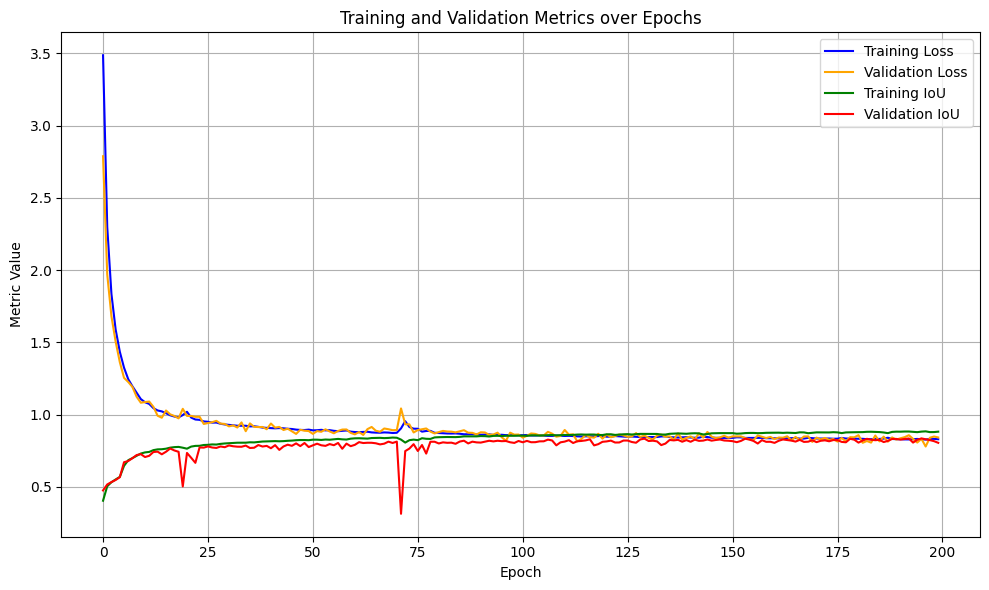

In [25]:
# Step 17: Visualize Training and Validation Metrics
plt.figure(figsize=(10, 6))

# Plotting Training Loss
plt.plot(train_loss_hist, label='Training Loss', color='blue')

# Plotting Validation Loss
plt.plot(val_loss_hist, label='Validation Loss', color='orange')

plt.plot(train_iou_hist, label='Training IoU', color='green')

# Plotting Validation IoU
plt.plot(val_iou_hist, label='Validation IoU', color='red')

plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.title('Training and Validation Metrics over Epochs')
plt.legend()
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [26]:
# Step 18: Save Model Weights
torch.save(model.cpu().state_dict(), model_path)

In [27]:
color_encoding = [
                ('a', (0, 0, 0)),    # Black
                ('b', (255, 0, 0)),  # Red
                ('c', (0, 255, 0)),  # Green
                ('d', (0, 0, 255)),  # Blue
                ('e', (255, 255, 0)),  # Yellow
                ('f', (0, 255, 255))   # Cyan
]

num_classes=7

def label_for_cross_entropy(label):
    """
        Convert label image to matrix classes for apply cross entropy loss.
        Return semantic index, label in enumemap of H x W x class
    """
    semantic_map = np.zeros(label.shape[:-1])
    # Fill all value with class 13 - default for all pixels
    semantic_map.fill(num_classes - 1)
    # Fill the pixel with correct class

    for class_index, color_info in enumerate(color_encoding):
        color = color_info[1]
        equality = np.equal(label, color)
        class_map = np.all(equality, axis=-1)
        semantic_map[class_map] = class_index
    return semantic_map

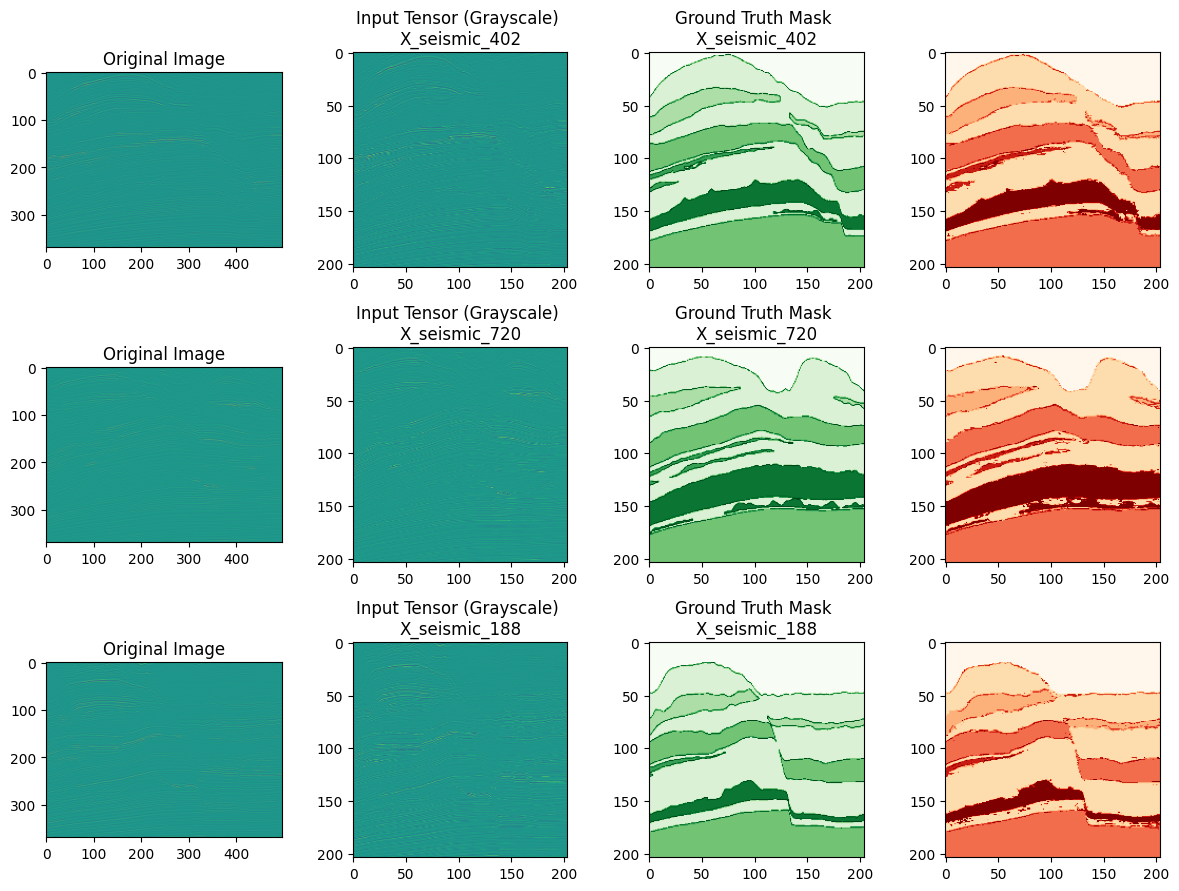

In [28]:
# Step 20: Evaluate Model on Sample Images
model = model.to(device)

# Set the model to evaluation mode
model.eval()

# Define the sample image names
names = ['X_seismic_402', 'X_seismic_720', 'X_seismic_188']
names2 = ['X_mask_402', 'X_mask_720', 'X_mask_188']

val_image_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_seismic'
val_mask_path = '/home/sang/Documents/Dataset/SEG_2020/extracted/X_mask'

# Load the sample images and masks
images = [Image.open(os.path.join(val_image_path, name+'.png')) for name in names]
images = [i.convert('RGB') for i in images]

masks = [Image.open(os.path.join(val_mask_path, name+'.png')) for name in names2]
masks = [i.convert('RGB') for i in masks]
masks = [np.array(i) for i in masks]
masks = [label_for_cross_entropy(i) for i in masks]
masks = [Image.fromarray(i) for i in masks]

# Apply transformations to convert images to tensors
transforms = T.Compose([T.ToTensor(), T.Resize((204, 204))])
x = torch.stack([transforms(image) for image in images])
y = torch.stack([transforms(mask) for mask in masks])

# Generate predictions using the model
# Assuming 'x' is your input tensor
x = x.to(device)  # Move input tensor to the same device as the model

# Generate predictions using the model
outputs, _, _ = model(x)
outputs =  outputs.squeeze()

output_temps = outputs 
outputs = np.array(outputs.detach().cpu())

# val_label = val_label.squeeze()
# val_label = np.array(val_label)

# Visualize the sample images, ground truth masks, and model predictions
fig = plt.figure(figsize=(12, 9))
for i in range(len(names)):
    # Plot original image
    ax = fig.add_subplot(3, 4, i*4+1)
    plt.imshow(images[i])
    ax.set_title("Original Image")

    # Plot input tensor
    ax = fig.add_subplot(3, 4, i*4+2)
    # Assuming x is your tensor on a CUDA device (GPU)
    # Move tensor x to CPU and then convert it to a NumPy array
    x_numpy = x[i].squeeze().cpu().numpy()
    
    x_numpy = np.transpose(x_numpy, (1, 2, 0))
    
    ax.imshow(x_numpy.squeeze(), cmap="Greys")
    ax.set_title(f'Input Tensor (Grayscale) \n{names[i]}')

    # Plot ground truth mask
    ax = fig.add_subplot(3, 4, i*4+3)
    ax.imshow(y[i].squeeze(), cmap="Greens")
    ax.set_title(f'Ground Truth Mask \n{names[i]}')
    
    # Plot model prediction
    ax = fig.add_subplot(3, 4, i*4+4)
    # Move tensor from GPU to CPU and then convert it to a NumPy array
    output = outputs[i].squeeze()
    
    # Convert NumPy array to PyTorch tensor
    output_tensor = torch.from_numpy(output)
    
    class_labels = torch.argmax(output_tensor, dim=0)
    class_labels_np = class_labels.cpu().numpy().astype(np.uint8)
    
    ax.imshow(class_labels_np, cmap="OrRd")
#     ax.set_title("Model Prediction\nmIoU: " + str(round(df_sorted[df_sorted['name'] == names[i]]['IoU'].values[0], 3)))

plt.tight_layout()
plt.show()